[LINK](https://colab.research.google.com/github/gordicaleksa/get-started-with-JAX/blob/main/Tutorial_1_JAX_Zero2Hero_Colab.ipynb)

In [57]:
import numpy as np 
from jax import lax 
from jax import random
import jax.numpy as jnp
from jax import make_jaxpr
from jax import device_put
import matplotlib.pyplot as plt
from jax import grad, jit, vmap, pmap 

In [58]:
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['axes.labelsize'] = 14
plt.style.use('seaborn-whitegrid')


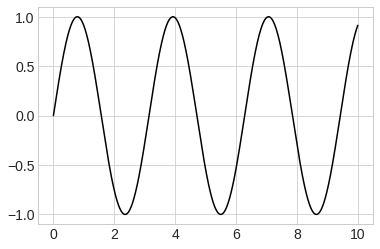

In [59]:
x_np = np.linspace(0,10,1000)
y_np = 2*np.sin(x_np) * np.cos(x_np)
plt.plot(x_np, y_np, c="k");

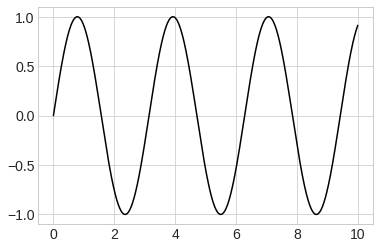

In [60]:
x_jnp = jnp.linspace(0,10,1000)
y_jnp = 2*jnp.sin(x_jnp) * jnp.cos(x_jnp)
plt.plot(x_jnp, y_jnp, c="k");

In [61]:
# immutable jax arrays

x = np.arange(10)
x[0] = 23
print(x)

x = jnp.arange(10)
# x[0] = 23 # JAX arrays are immutable
x = x.at[0].set(23)
print(x)


[23  1  2  3  4  5  6  7  8  9]
[23  1  2  3  4  5  6  7  8  9]


In [62]:
# random numbers
seed = 0
key = random.PRNGKey(seed)
x = random.normal(key, (5,))
print(type(x), x)

<class 'jaxlib.xla_extension.Array'> [ 0.18784384 -1.2833426  -0.2710917   1.2490593   0.24447003]


In [63]:
size = 3000
x_jnp = random.normal(key, (size,size), dtype=jnp.float32)
x_np = np.random.normal(size=(size,size)).astype(np.float32)

%timeit jnp.dot(x_jnp, x_jnp.T).block_until_ready()
%timeit np.dot(x_np, x_np.T)
%timeit jnp.dot(x_np, x_np.T).block_until_ready()


x_np_device = device_put(x_np)  # push NumPy explicitly to GPU
%timeit jnp.dot(x_np_device, x_np_device.T).block_until_ready()  # same as 1)


54.6 ms ± 245 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
455 ms ± 95.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
103 ms ± 664 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
54.8 ms ± 215 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [64]:
# where is the data by default?
from jax import numpy as jnp
print(jnp.ones(3).device_buffer.device())  

gpu:0


- Jax transform functions

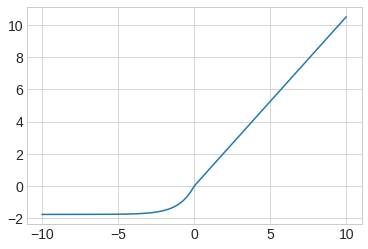

In [65]:
def visualize_fn(fn, l=-10, r=10, n=1000):
    x = np.linspace(l, r, num=n)
    y = fn(x)
    plt.plot(x, y) 
    plt.show()

def selu(x, alpha=1.67, lmbda=1.05):  # note: SELU is an activation function
    return lmbda * jnp.where(x > 0, x, alpha * jnp.exp(x) - alpha)

visualize_fn(selu)

In [66]:
data = random.normal(key, (int(1e6),))
selu_jit = jit(selu)
print(' not-jitted:')
%timeit selu(data).block_until_ready()
print(' jitted:')
%timeit selu_jit(data).block_until_ready()

 not-jitted:
1.52 ms ± 27.5 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
 jitted:
393 µs ± 17.6 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


- grad() automatic

In [67]:
def sum_logistic(x):  # or maybe a simpler example: sum of squares? (jnp.sum(x**2))
    # return jnp.sum(1.0 / (1.0 + jnp.exp(-x)))
    return jnp.sum(x**2)

x = jnp.arange(3.)
loss = sum_logistic

# By default grad calculates the derivative of a fn w.r.t. 1st parameter!
# Here we bundled inputs into a 1st param so it doesn't matter.
grad_loss = grad(loss)
print(grad_loss(x))

[0. 2. 4.]


In [68]:
# Numeric diff (to double check that autodiff works correctly)
def finite_differences(f, x):
    eps = 1e-3
    # f(0+e, 1, 2) - f(0-e, 1, 2) / 2e
    return jnp.array([(f(x + eps * v) - f(x - eps * v)) / (2 * eps)  # derivative definition
                                for v in jnp.eye(len(x))])

In [69]:
for v in jnp.eye(len(x)):
    print(v, len(v))

[1. 0. 0.] 3
[0. 1. 0.] 3
[0. 0. 1.] 3


In [70]:
print(finite_differences(loss, x))

[0.        1.9998549 3.9999483]


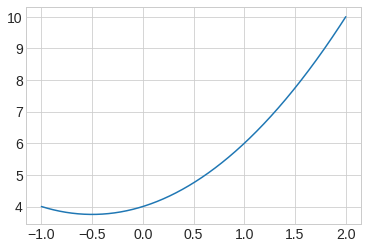

6.0 3.0 2.0 0.0


In [71]:
# example (automatic diff)
x = 1.0
f = lambda x: x**2 + x + 4
visualize_fn(f, l=-1, r=2, n=1000)

dfdx = grad(f)      # dfdx = lambda x: 2*x + 1
d2fdx = grad(dfdx)  # d2fdx = lambda x: 2
d3fdx = grad(d2fdx) # d3fdx = lambda x: 0

print(f(x), dfdx(x), d2fdx(x), d3fdx(x))

In [72]:
# advanced example (automatic diff)
from jax import jacfwd, jacrev

f = lambda x, y: x**2 + y**2

# df/dx = 2x
# df/dy = 2y
# J = [df/dx, df/dy]

# d2f/dx2 = 2
# d2f/dy2 = 2
# d2f/dxdy = 0
# d2f/dydx = 0
# H = [[d2f/dx2, d2f/dxdy], [d2f/dydx, d2f/dy2]]

def hessian(f):
    return jit(jacfwd(jacrev(f, argnums=(0,1)), argnums=(0,1)))

In [73]:
# Jacobian of f
jacrev(f, argnums=(0, 1))(1., 1.)

(Array(2., dtype=float32, weak_type=True),
 Array(2., dtype=float32, weak_type=True))

In [74]:
# Hessian of f
hessian(f)(1., 1.)

((Array(2., dtype=float32, weak_type=True),
  Array(0., dtype=float32, weak_type=True)),
 (Array(0., dtype=float32, weak_type=True),
  Array(2., dtype=float32, weak_type=True)))

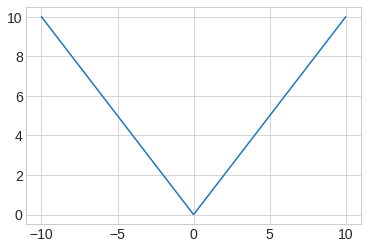

1 1
1.0


In [75]:
# Edge case |x|, how does JAX handle it?
f = lambda x: abs(x)
visualize_fn(f)

print(f(-1), f(1))
dfdx = grad(f)
print(dfdx(0.)) # play with numbers around 0 and see how JAX handles it

In [76]:
# Example 1: lax is stricter

print(jnp.add(1, 1.0))  # jax.numpy API implicitly promotes mixed types
# print(lax.add(1, 1.0))  # jax.lax API requires explicit type promotion

2.0


In [77]:
# Why JIT? -> jitted functions are much faster.

def norm(X):
    X = X - X.mean(0)
    return X / X.std(0)

norm_compiled = jit(norm)

X = random.normal(key, (10000, 100), dtype=jnp.float32)

assert np.allclose(norm(X), norm_compiled(X), atol=1E-6)

%timeit norm(X).block_until_ready()
%timeit norm_compiled(X).block_until_ready()

1.12 ms ± 109 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
1.01 ms ± 33.5 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [78]:
# Example of a failure: array shapes must be static
def get_negatives(x):
    return x[x < 0]

x = random.normal(key, (10,), dtype=jnp.float32)
print(get_negatives(x))

[-0.3721109  -0.18252768 -0.7368197  -0.44030377 -0.1521442  -0.67135346
 -0.5908641 ]


In [79]:
# Example of a failure: array shapes must be static
# print(jit(get_negatives)(x)) # fails

In [80]:
# So how does it work in the background? -> tracing on different levels of abstraction

@jit
def f(x, y):
    print("Running f():")
    print(f"  x = {x}")
    print(f"  y = {y}")
    result = jnp.dot(x + 1, y + 1)
    print(f"  result = {result}")
    return result

x = np.random.randn(3, 4)
y = np.random.randn(4)
print(f(x, y))

x2 = np.random.randn(3, 4)
y2 = np.random.randn(4)
print('Second call:')
print(f(x2, y2))  # Oops! Side effects (like print) are not compiled...

# Note: any time we get the same shapes and types we just call the compiled fn!

Running f():
  x = Traced<ShapedArray(float32[3,4])>with<DynamicJaxprTrace(level=0/1)>
  y = Traced<ShapedArray(float32[4])>with<DynamicJaxprTrace(level=0/1)>
  result = Traced<ShapedArray(float32[3])>with<DynamicJaxprTrace(level=0/1)>
[9.039814  2.4488041 7.1603413]
Second call:
[2.7090325 2.6556253 2.5315974]


In [81]:
# Same function as above just without the print statements
def f(x, y):
    return jnp.dot(x + 1, y + 1)

print(make_jaxpr(f)(x, y))

{ lambda ; a:f32[3,4] b:f32[4]. let
    c:f32[3,4] = add a 1.0
    d:f32[4] = add b 1.0
    e:f32[3] = dot_general[
      dimension_numbers=(((1,), (0,)), ((), ()))
      precision=None
      preferred_element_type=None
    ] c d
  in (e,) }


In [82]:
# In-Place Updates
jax_array = jnp.zeros((3,3), dtype=jnp.float32)
updated_array = jax_array.at[1, :].set(1.0)


In [83]:
jax_array

Array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]], dtype=float32)

In [84]:
updated_array 

Array([[0., 0., 0.],
       [1., 1., 1.],
       [0., 0., 0.]], dtype=float32)

In [85]:
print("original array:")
jax_array = jnp.ones((5, 6))
print(jax_array)

print("new array post-addition:")
new_jax_array = jax_array.at[::2, 3:].add(7.)
print(new_jax_array)

original array:
[[1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1.]]
new array post-addition:
[[1. 1. 1. 8. 8. 8.]
 [1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 8. 8. 8.]
 [1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 8. 8. 8.]]


In [86]:
# out of bound indexing
try:
  np.arange(10)[11]
except Exception as e:
    print("Exception {}".format(e))

Exception index 11 is out of bounds for axis 0 with size 10


In [87]:
# in general there are currently some bugs so just consider the behavior undefined!
print(jnp.arange(10).at[11].add(23))  # example of 1)
print(jnp.arange(10)[11])  # example of 2)

[0 1 2 3 4 5 6 7 8 9]
9


In [88]:
print(np.sum([1, 2, 3]))

try:
    jnp.sum([1, 2, 3])
except TypeError as e:
    print(f"TypeError: {e}")

print(jnp.sum(jnp.array([1, 2, 3])))

6
TypeError: sum requires ndarray or scalar arguments, got <class 'list'> at position 0.
6


In [89]:
def permissive_sum(x):
    return jnp.sum(jnp.array(x))

x = list(range(10))
print(make_jaxpr(permissive_sum)(x))

{ lambda ; a:i32[] b:i32[] c:i32[] d:i32[] e:i32[] f:i32[] g:i32[] h:i32[] i:i32[]
    j:i32[]. let
    k:i32[] = convert_element_type[new_dtype=int32 weak_type=False] a
    l:i32[] = convert_element_type[new_dtype=int32 weak_type=False] b
    m:i32[] = convert_element_type[new_dtype=int32 weak_type=False] c
    n:i32[] = convert_element_type[new_dtype=int32 weak_type=False] d
    o:i32[] = convert_element_type[new_dtype=int32 weak_type=False] e
    p:i32[] = convert_element_type[new_dtype=int32 weak_type=False] f
    q:i32[] = convert_element_type[new_dtype=int32 weak_type=False] g
    r:i32[] = convert_element_type[new_dtype=int32 weak_type=False] h
    s:i32[] = convert_element_type[new_dtype=int32 weak_type=False] i
    t:i32[] = convert_element_type[new_dtype=int32 weak_type=False] j
    u:i32[1] = broadcast_in_dim[broadcast_dimensions=() shape=(1,)] k
    v:i32[1] = broadcast_in_dim[broadcast_dimensions=() shape=(1,)] l
    w:i32[1] = broadcast_in_dim[broadcast_dimensions=() shap

In [90]:
key = random.PRNGKey(seed)
print(random.normal(key, (1,)))
print(random.normal(key, (1,))) # oops - same results?
# solution?
print("old key:", key)
key, subkey = random.split(key)
normal_samples = random.normal(subkey, (1,))
print("\---SPLIT --> new key   ", key)
print("\--> new subkey", subkey, "--> normal", normal_samples)

# Note1: you can also split into more subkeys and not just 1
# Note2: key, subkey no difference it's only a convention

[-0.20584226]
[-0.20584226]
old key: [0 0]
\---SPLIT --> new key    [4146024105  967050713]
\--> new subkey [2718843009 1272950319] --> normal [-1.2515389]


In [91]:
# Why this design? 
# Well...think...with current design can the code be:
# 1) reproducible?
# 2) parallelizable?
# 3) vectorisable?

np.random.seed(seed)

def bar(): return np.random.uniform()
def baz(): return np.random.uniform()

# e.g. bar=0.3 baz=0.4 [0.3 + 2*0.4] [0.4 + 2*0.3] -> not reproducible in parallel envs!
def foo(): return bar() + 2 * baz()

print(foo())

# What if we want to parallelize this code? NumPy assumes too much. 2) is violated.

1.9791922366721637


In [92]:
# NumPy
np.random.seed(seed)
print("individually:", np.stack([np.random.uniform() for _ in range(3)]))

np.random.seed(seed)
print("all at once: ", np.random.uniform(size=3))

# JAX
key = random.PRNGKey(seed)
subkeys = random.split(key, 3)
sequence = np.stack([random.normal(subkey) for subkey in subkeys])
print("individually:", sequence)

key = random.PRNGKey(seed)
print("all at once: ", random.normal(key, shape=(3,)))

# NumPy violates 3)

individually: [0.5488135  0.71518937 0.60276338]
all at once:  [0.5488135  0.71518937 0.60276338]
individually: [1.1188384 0.5781488 0.8535516]
all at once:  [ 1.8160863  -0.48262316  0.33988908]
